GROND_TRUTH_LOG_LIK = -1707.7475610212805
-18089.859156267652 -1707.7475610212805
[0.502 0.923 1.    1.    0.997 0.997 0.997 0.996 0.685 0.284 0.995 0.643
 0.48  1.    0.983 0.994 0.892 0.663 0.246 0.979 0.578 0.207 0.51  0.536
 0.927 0.996 0.958 0.994 0.81  0.468]


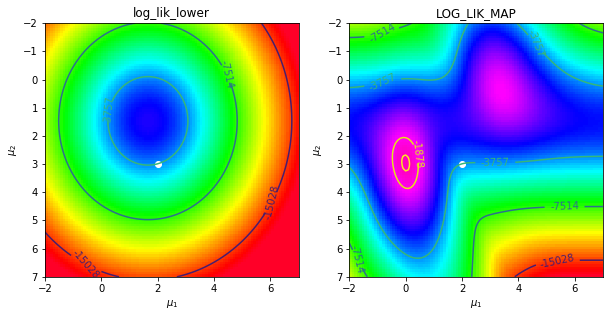

-3768.427460706547
-3768.427460706547


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# GENERATING SAMPLES FROM GROUND TRUTH
PROB_TRUE = .5  # probability if it lies from normal distribution 2 
MEAN_1_TRUE = 0.
STDE_1_TRUE = .5
MEAN_2_TRUE = 3.
STDE_2_TRUE = 1.

LENGTH = 1000
SAMPLES = [STDE_1_TRUE * np.random.randn() + MEAN_1_TRUE
           if np.random.random() > PROB_TRUE 
           else STDE_2_TRUE * np.random.randn() + MEAN_2_TRUE
           for _ in range(LENGTH)]

def calc_log_lik_(mean_1_, mean_2_):
    return np.sum(
            np.log(
                ((1-PROB_TRUE)/(STDE_1_TRUE*np.sqrt(2*np.pi)))
                  *np.exp(-np.power(np.add(SAMPLES,[-mean_1_]*LENGTH),2)/(2*STDE_1_TRUE**2))
                + (PROB_TRUE/(STDE_2_TRUE*np.sqrt(2*np.pi)))
                  *np.exp(-np.power(np.add(SAMPLES,[-mean_2_]*LENGTH),2)/(2*STDE_2_TRUE**2))))

calc_log_lik = np.vectorize(calc_log_lik_)
GROND_TRUTH_LOG_LIK = calc_log_lik(MEAN_1_TRUE, MEAN_2_TRUE)

print("GROND_TRUTH_LOG_LIK = {}".format(GROND_TRUTH_LOG_LIK))


import matplotlib.colors as colors
import matplotlib.cm as cm
import copy

MEAN_1_PLT_START, MEAN_1_PLT_END, MEAN_2_PLT_START, MEAN_2_PLT_END = -2,7,-2,7
PLOT_EXTENT=[MEAN_1_PLT_START, MEAN_1_PLT_END, MEAN_2_PLT_END, MEAN_2_PLT_START]
CONT_EXTENT=[MEAN_1_PLT_START, MEAN_1_PLT_END, MEAN_2_PLT_START, MEAN_2_PLT_END]

MEAN_1_LINSPACE = np.linspace(MEAN_1_PLT_START, MEAN_1_PLT_END, 100)
MEAN_2_LINSPACE = np.linspace(MEAN_2_PLT_START, MEAN_2_PLT_END, 100)

MEAN_1_GRID, MEAN_2_GRID = np.meshgrid(MEAN_1_LINSPACE, MEAN_2_LINSPACE)

LOG_LIK_MAP = calc_log_lik(MEAN_1_GRID, MEAN_2_GRID)
LOG_LIK_MAX = np.max(LOG_LIK_MAP)
LOG_LIK_MIN = np.min(LOG_LIK_MAP)
print(LOG_LIK_MIN,LOG_LIK_MAX)
assert LOG_LIK_MAX < 0  # so that countour levels make sense

prob, mean_1, stde_1, mean_2, stde_2 = PROB_TRUE, 2., STDE_1_TRUE, 3., STDE_2_TRUE

def plot_ell():
    fig1 = plt.figure(figsize=(5,5))
    ax1 = fig1.add_subplot(111)
    ax1.imshow(LOG_LIK_MAP,
               extent = PLOT_EXTENT,
               cmap=cm.gist_rainbow,
               norm = colors.SymLogNorm(vmax=LOG_LIK_MAX, vmin=LOG_LIK_MIN, linthresh=1, clip=True))

    CS = plt.contour(LOG_LIK_MAP,
                    extent = CONT_EXTENT,
                    norm = colors.SymLogNorm(vmax=LOG_LIK_MAX, vmin=LOG_LIK_MIN, linthresh=1),
                    levels=[LOG_LIK_MAX*3., LOG_LIK_MAX*1.5, LOG_LIK_MAX*1.1]
                    )
    ax1.clabel(CS, inline=1, fontsize=10, fmt="%d")
    ax1.set_xlabel("$\mu_1$")
    ax1.set_ylabel("$\mu_2$")
    plt.show()
# plot_ell()

def expectation_step(prob_,mean_1_,stde_1_,mean_2_,stde_2_):
    odds_Y1 = [((1-prob_)/(stde_1_*np.sqrt(2*np.pi))) 
                * np.exp(-(np.add(SAMPLES,[-mean_1_]*LENGTH))**2. / (2. * stde_1_**2))]
    odds_Y2 = [((prob_)/(stde_2_*np.sqrt(2*np.pi))) 
                * np.exp(-(np.add(SAMPLES,[-mean_2_]*LENGTH))**2. / (2. * stde_2_**2))]
    return np.divide(odds_Y2,np.add(odds_Y1,odds_Y2))[0]

gamma_i = expectation_step(prob,mean_1,stde_1,mean_2,stde_2)
print(np.round(gamma_i[:30],3))  # the gamma values of some of the SAMPLES


from scipy.special import xlogy  # calculates x*log(y)

def calc_log_lik_lower_(mean_1_,mean_2_):
    odds_Y1 = [((1-prob)/(stde_1*np.sqrt(2.*np.pi))) 
                * np.exp(-np.power(np.add(SAMPLES,[-mean_1_]*LENGTH),2.) / (2. * stde_1**2))]
    odds_Y2 = [((prob)/(stde_2*np.sqrt(2.*np.pi))) 
                * np.exp(-np.power(np.add(SAMPLES,[-mean_2_]*LENGTH),2.) / (2. * stde_2**2))]
    return np.sum(np.add(np.add(xlogy(gamma_i, odds_Y2),-xlogy(gamma_i,gamma_i)),
                         np.add(xlogy(1-gamma_i, odds_Y1),-xlogy(1-gamma_i, 1-gamma_i))))

calc_log_lik_lower = np.vectorize(calc_log_lik_lower_)


def plot_ell_compare(log_lik_lower_map_):
    fig1 = plt.figure(figsize=(10,10))
    ax1 = fig1.add_subplot(121)
    ax1.imshow(log_lik_lower_map_,
               extent = PLOT_EXTENT,
               cmap=cm.gist_rainbow,
               norm = colors.SymLogNorm(vmax=LOG_LIK_MAX, vmin=LOG_LIK_MIN, linthresh=1, clip=True)
              )
    CS = ax1.contour(log_lik_lower_map_,
           extent = CONT_EXTENT,
           norm = colors.SymLogNorm(vmax=LOG_LIK_MAX, vmin=LOG_LIK_MIN, linthresh=1, clip=True),
                    levels=[LOG_LIK_MAX*8.8, LOG_LIK_MAX*4.4, LOG_LIK_MAX*2.2, LOG_LIK_MAX*1.1, LOG_LIK_MAX*1.01]
                    )
    
    ax1.clabel(CS, inline=1, fontsize=10, fmt="%d")
    ax1.set_xlabel("$\mu_1$")
    ax1.set_ylabel("$\mu_2$")
    ax1.set_title("log_lik_lower")
    ax1.scatter(mean_1,mean_2,color="white")

    ax2 = fig1.add_subplot(122)
    ax2.imshow(LOG_LIK_MAP,
           extent = PLOT_EXTENT,
           cmap=cm.gist_rainbow,
           norm = colors.SymLogNorm(vmax=LOG_LIK_MAX, vmin=LOG_LIK_MIN, linthresh=1, clip=True)
          )
    ax2.scatter(mean_1,mean_2,color="white")

    CS = plt.contour(LOG_LIK_MAP,
                     extent = CONT_EXTENT,
                     norm = colors.SymLogNorm(vmax=LOG_LIK_MAX, vmin=LOG_LIK_MIN, linthresh=1, clip=True),
                     levels=[LOG_LIK_MAX*8.8, LOG_LIK_MAX*4.4, LOG_LIK_MAX*2.2, LOG_LIK_MAX*1.1, LOG_LIK_MAX*1.01]
                    )
    ax2.clabel(CS, inline=1, fontsize=10, fmt="%d")
    ax2.set_xlabel("$\mu_1$")
    ax2.set_ylabel("$\mu_2$")
    ax2.set_title("LOG_LIK_MAP")
    plt.show()
    
    
plot_ell_compare(calc_log_lik_lower(MEAN_1_GRID, MEAN_2_GRID))
print(calc_log_lik_lower_(mean_1,mean_2))
print(calc_log_lik(mean_1,mean_2))

/anaconda3/envs/dw/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/anaconda3/envs/dw/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


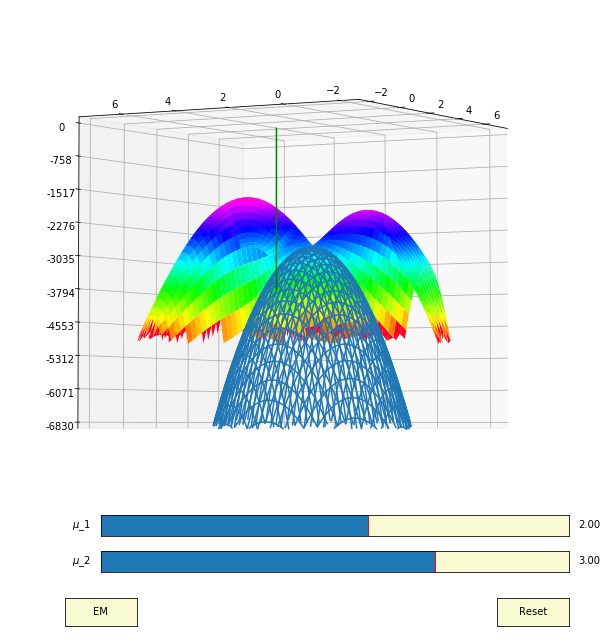

In [2]:
%matplotlib tk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import copy

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
LOG_LIK_MAP_ = copy.deepcopy(LOG_LIK_MAP)
LOG_LIK_MAP_[LOG_LIK_MAP_<-5000.] = np.nan

surf = ax.plot_surface(MEAN_1_GRID, MEAN_2_GRID, LOG_LIK_MAP_,
                cmap=cm.gist_rainbow,
                vmin=3.*LOG_LIK_MAX,
                vmax=LOG_LIK_MAX)

# plot log_lik_lower
log_lik_lower = calc_log_lik_lower(MEAN_1_GRID, MEAN_2_GRID)
log_lik_lower[log_lik_lower<-7000.] = np.nan
wire = ax.plot_wireframe(MEAN_1_GRID, MEAN_2_GRID, log_lik_lower)
line = ax.plot([mean_1,mean_1],[mean_2,mean_2],[0,calc_log_lik_lower(mean_1, mean_2)],
               color = 'g')

ax.view_init(-3, 210)
ax.set_zlim3d(LOG_LIK_MAX*4., 0)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%d'))

# configuring sliders
axcolor = 'lightgoldenrodyellow'
ax_mean_1 = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)
ax_mean_2 = plt.axes([0.25, 0.10, 0.65, 0.03], facecolor=axcolor)
mean_1_init = mean_1
mean_2_init = mean_2
s_mean_1 = Slider(ax_mean_1, '$\mu$_1', -2.0, 5.0, valinit=mean_1_init)
s_mean_2 = Slider(ax_mean_2, '$\mu$_2', -2.0, 5.0, valinit=mean_2_init)

def updated_slider(val):
    global mean_1
    global mean_2
    global gamma_i  # needed to modify global copy of globvar
    mean_1 = s_mean_1.val
    mean_2 = s_mean_2.val
    gamma_i = expectation_step(prob,mean_1,stde_1,mean_2,stde_2)
    log_lik_lower = calc_log_lik_lower(MEAN_1_GRID, MEAN_2_GRID)
    log_lik_lower[log_lik_lower<-7000.] = np.nan
    
    print("prob = {:.4f}, mean_1 = {:.4f}, stde_1 = {:.4f}, mean_2 = {:.4f}, stde_2 = {:.4f}"
      .format(prob,mean_1,mean_2,stde_1,stde_2))
    
    print(list(ax.collections))
    ax.collections.remove(list(ax.collections)[-1])  # delete old wire
        
    wire = ax.plot_wireframe(MEAN_1_GRID, MEAN_2_GRID, log_lik_lower)
    line = ax.plot([mean_1,mean_1],[mean_2,mean_2],[0,calc_log_lik_lower(mean_1, mean_2)],
                   color = 'g')
    fig.canvas.draw()
    
mean_1_on_change_cid = s_mean_1.on_changed(updated_slider)
mean_2_on_change_cid = s_mean_2.on_changed(updated_slider)


def updated_em(val):
    s_mean_1.disconnect(mean_1_on_change_cid)
    s_mean_2.disconnect(mean_2_on_change_cid)
    global prob
    global mean_1
    global stde_1
    global mean_2
    global stde_2
    global gamma_i  # needed to modify global copy of globvar
    gamma_i = expectation_step(prob,mean_1,stde_1,mean_2,stde_2)
    results = maximisation_step(gamma_i)
#     prob = results[0]
    mean_1, mean_2 = results[1], results[3]
#     stde_1, stde_2 = results[2], results[4]
    s_mean_1.set_val(mean_1)
    s_mean_2.set_val(mean_2)
    print("reached?")
    gamma_i = expectation_step(prob,mean_1,stde_1,mean_2,stde_2)
    log_lik_lower = calc_log_lik_lower(MEAN_1_GRID, MEAN_2_GRID)
    log_lik_lower[log_lik_lower<-7000.] = np.nan
    
    print("prob = {:.4f}, mean_1 = {:.4f}, stde_1 = {:.4f}, mean_2 = {:.4f}, stde_2 = {:.4f}"
      .format(prob,mean_1,mean_2,stde_1,stde_2))
    
    print(list(ax.collections))
    ax.collections.remove(list(ax.collections)[-1])  # delete old wire
        
    wire = ax.plot_wireframe(MEAN_1_GRID, MEAN_2_GRID, log_lik_lower)
    line = ax.plot([mean_1,mean_1],[mean_2,mean_2],[0,calc_log_lik_lower(mean_1, mean_2)],
                   color = 'g')

    fig.canvas.draw()

def reset(event):
    s_mean_1.reset()
    s_mean_2.reset()

reset_ax = plt.axes([0.8, 0.025, 0.1, 0.04])
button_reset = Button(reset_ax, 'Reset', color=axcolor, hovercolor='0.975')
button_reset.on_clicked(reset)


def maximisation_step(gamma_i):
    gamma_1_i = 1 - gamma_i
    prob = np.sum(gamma_i)/LENGTH
    mean_1 = np.sum(np.multiply(gamma_1_i,SAMPLES)) / np.sum(gamma_1_i)
    mean_2 = np.sum(np.multiply(gamma_i,SAMPLES)) / np.sum(gamma_i)
    stde_1 = np.sqrt(np.sum(np.multiply(gamma_1_i,
                            np.power(np.add(SAMPLES,[-mean_1]*LENGTH),2)))/np.sum(gamma_1_i))
    stde_2 = np.sqrt(np.sum(np.multiply(gamma_i,
                            np.power(np.add(SAMPLES,[-mean_2]*LENGTH),2)))/np.sum(gamma_i))
    return prob,mean_1,stde_1,mean_2,stde_2

    
next_ax = plt.axes([0.2, 0.025, 0.1, 0.04])
button_next = Button(next_ax, 'EM', color=axcolor, hovercolor='0.975')
button_next.on_clicked(updated_em)

plt.show()